In [1]:
!nvidia-smi

Sat Jan 15 10:21:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load dependencies

In [2]:
!pip install torchtext==0.6.0

     |████████████████████████████████| 64 kB 1.1 MB/s 
     |████████████████████████████████| 1.2 MB 11.0 MB/s 
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.11.0
    Uninstalling torchtext-0.11.0:
      Successfully uninstalled torchtext-0.11.0


In [3]:
!pip install tqdm --upgrade >> /dev/null 2>&1
#!pip install torchtext --upgrade >> /dev/null 2>&1
!pip install spacy --upgrade >> /dev/null 2>&1
!python -m spacy download de >> /dev/null 2>&1
!python -m spacy download en >> /dev/null 2>&1

In [4]:
import tqdm
import spacy
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import display, HTML

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.data import Dataset, Example, Field
from torchtext.data.iterator import BucketIterator
from torchtext.data.metrics import bleu_score
from torchtext.datasets import Multi30k

In [5]:
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

SEED = 546
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')

Device: cuda


In [6]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
!ls '/content/drive/MyDrive/data_europarl/'

Mounted at /content/drive
0_no_noise  1_noise  2_noise  3_noise  4_noise	5_noise  6_noise  7_noise


#### Build vocabularies

In [7]:
%%time
FR_TEXT = Field(lower=True,  tokenizer_language='fr', include_lengths=True)
EN_TEXT = Field(init_token='<sos>', eos_token='<eos>', lower=True, tokenizer_language='en', include_lengths=True)
train, valid, test = Multi30k.splits(exts=('.fr', '.en'),  fields=(FR_TEXT, EN_TEXT), root = '/content/drive/MyDrive/data_europarl/6_noise')
print(f'train set size: {len(train.examples):,}')
print(f'valid set size: {len(valid.examples):,}')
print(f'test set size: {len(test.examples):,}')
# print(vars(DE))
# print(vars(EN))

train set size: 29,824
valid set size: 996
test set size: 987
CPU times: user 945 ms, sys: 64.3 ms, total: 1.01 s
Wall time: 2.7 s


In [8]:
%%time
MIN_COUNT = 2
FR_TEXT.build_vocab(train, min_freq=MIN_COUNT, specials=['<unk>', '<pad>'])
EN_TEXT.build_vocab(train, min_freq=MIN_COUNT, specials=['<sos>', '<eos>', '<unk>', '<pad>'])
print(f'Length of FR vocabulary: {len(FR_TEXT.vocab):,}')
print(f'Length of EN vocabulary: {len(EN_TEXT.vocab):,}')

Length of FR vocabulary: 11,545
Length of EN vocabulary: 8,777
CPU times: user 344 ms, sys: 2.12 ms, total: 347 ms
Wall time: 344 ms


# Model 6
data is added noise type 6

#### Encoder layer

In [9]:
class EncoderLayer(nn.Module):

    def __init__(self, vocab_size, embedding_size, hidden_size, n_layers, embedding_dropout, recurrent_dropout):
        super(EncoderLayer, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.embedding_dropout = embedding_dropout
        self.recurrent_dropout = recurrent_dropout if n_layers > 1 else 0
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.gru = nn.GRU(embedding_size, hidden_size, num_layers=n_layers, dropout=self.recurrent_dropout, bidirectional=True)

    def forward(self, input_sequences, sequence_lengths):
        """
        :param Tensor[seq_len, batch_size] input_sequences
        :param Tensor[batch_size,] sequence_lengths
        :return Tensor[n_layers * 2, batch_size, hidden_size] h_state
        """
        embedded = self.embedding(input_sequences)
        embedded = F.dropout(embedded, p=self.embedding_dropout)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, sequence_lengths.cpu())
        _, h_state = self.gru(packed)
        return h_state

#### Decoder layer

In [10]:
class DecoderLayer(nn.Module):

    def __init__(self, vocab_size, embedding_size, hidden_size, n_layers, embedding_dropout, recurrent_dropout):
        super(DecoderLayer, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.embedding_dropout = embedding_dropout
        self.recurrent_dropout = recurrent_dropout if n_layers > 1 else 0
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.gru = nn.GRU(embedding_size, hidden_size, num_layers=n_layers, dropout=self.recurrent_dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, input_word_index, h_state_prev):
        """
        :param Tensor[batch_size,] input_word_index
        :param Tensor[n_layers, batch_size, hidden_size] h_state_prev
        :return Tensor[batch_size, vocab_size] logit
        :return Tensor[n_layers, batch_size, hidden_size] h_state
        """
        embedded = self.embedding(input_word_index.unsqueeze(0))
        embedded = F.dropout(embedded, p=self.embedding_dropout)
        outputs, h_state = self.gru(embedded, h_state_prev)
        logit = self.fc(outputs.squeeze(0))
        return logit, h_state

#### Sequence-to-sequence model

In [11]:
class SeqToSeqNet(nn.Module):

    def __init__(self, encoder, decoder, device):
        assert encoder.n_layers == decoder.n_layers, 'Encoder and Decoder must have the same number of reccurent layers'
        assert encoder.hidden_size == decoder.hidden_size, 'Encoder and Decoder must have the same number of reccurrent hidden units'
        super(SeqToSeqNet, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.init_h0 = nn.Linear(encoder.n_layers * 2, decoder.n_layers)

    def encode(self, input_sequences, sequence_lengths):
        h_state = self.encoder(input_sequences, sequence_lengths)
        h_state = self.init_h0(h_state.permute(1, 2, 0)) # [batch_size, hidden_size, n_layers]
        h_state = h_state.permute(2, 0, 1) # [n_layers, batch_size, hidden_size]
        return h_state

    def sort_batches(self, dest_sequences, dest_lengths, h_state):
        sorted_dest_lengths, sorted_indices = torch.sort(dest_lengths, dim=0, descending=True)
        sorted_dest_sequences = dest_sequences[:, sorted_indices]
        h_state = h_state[:, sorted_indices, :]
        # We won't decode at the <eos> position, since we've finished generating as soon as we generate <eos>.
        # So, decoding lengths are actual lengths - 1
        sorted_decode_lengths = (sorted_dest_lengths - 1).tolist() 
        return sorted_dest_sequences, sorted_decode_lengths, h_state

    def decode(self, h_state, sorted_dest_sequences, sorted_decode_lengths, tf_ratio):
        batch_size, last = sorted_dest_sequences.size(1), None
        logits = torch.zeros(max(sorted_decode_lengths), batch_size, self.decoder.vocab_size).to(self.device)
        for t in range(max(sorted_decode_lengths)):
            batch_size_t = sum([l > t for l in sorted_decode_lengths])
            if last is not None:
                if np.random.rand() < tf_ratio:
                    input_word_index = last[:batch_size_t] # in_ [batch_size,]
                else:
                    input_word_index = sorted_dest_sequences[t, :batch_size_t] # in_ [batch_size,]
            else:
                input_word_index = sorted_dest_sequences[t, :batch_size_t] # in_ [batch_size,]
            logit, h_state = self.decoder(input_word_index, h_state[:, :batch_size_t, :].contiguous())
            # logit: [batch_size, vocab_size] - h_state: [n_layers, batch_size, hidden_size]
            logits[t, :batch_size_t, :] = logit
            last = torch.argmax(F.softmax(logit, dim=1), dim=1) # [batch_size,]
        return logits
    
    def forward(self, French_sequences, French_lengths, dest_sequences, dest_lengths, tf_ratio):
        """
        :param Tensor[seq_len, batch_size] French_sequences
        :param Tensor[batch_size,] French_lengths
        :param Tensor[seq_len, batch_size] dest_sequences
        :param Tensor[batch_size,] dest_lengths
        :param float tf_ratio
        :return Tensor[max(decode_lengths), batch_size, vocab_size] logits
        :return Tensor[seq_len, batch_size] sorted_dest_sequences
        :return list[max(decode_lengths) - 1] sorted_decode_lengths
        """
        h_state = self.encode(French_sequences, French_lengths)
        sorted_dest_sequences, sorted_decode_lengths, h_state = self.sort_batches(dest_sequences, dest_lengths, h_state)
        logits = self.decode(h_state, sorted_dest_sequences, sorted_decode_lengths, tf_ratio)
        return logits, sorted_dest_sequences, sorted_decode_lengths

#### Training routines

In [12]:
class AverageMeter:
    
    def __init__(self):
        self.value = 0.
        self.sum = 0.
        self.count = 0
        self.average = 0.
        
    def reset(self):
        self.value = 0.
        self.sum = 0.
        self.count = 0
        self.average = 0.
        
    def update(self, value, n=1):
        self.value = value
        self.sum += value * n
        self.count += n
        self.average = self.sum / self.count

In [13]:
def accuracy(outputs, target_sequences, k=5):
    batch_size = outputs.size(1)
    _, indices = outputs.topk(k, dim=1, largest=True, sorted=True)
    correct = indices.eq(target_sequences.view(-1, 1).expand_as(indices))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / batch_size)

In [14]:
class Trainer:

    def __init__(self, model, optimizer, criterion, train_iterator, valid_iterator):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_iterator = train_iterator
        self.valid_iterator = valid_iterator

    def clip_gradients(self, grad_clip):
        if grad_clip is not None:
            for group in self.optimizer.param_groups:
                for param in group['params']:
                    if param.grad is not None:
                        param.grad.data.clamp_(-grad_clip, grad_clip)

    def adjust_lr(self, shrink_factor=0.9, verbose=True):
        if verbose:
            print("\nDecaying learning rate.")
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * shrink_factor
        if verbose:
            print("The new learning rate is %f\n" % (self.optimizer.param_groups[0]['lr'],))
    
    def adjust_tf(self, tf_ratio, shrink_factor=0.9, verbose=False):
        tf_ratio = tf_ratio * shrink_factor
        if verbose:
            print("The teacher forcing rate is %f\n" % (tf_ratio,))
        return tf_ratio
    
    def train_step(self, epoch, grad_clip, tf_ratio):
        loss_tracker, acc_tracker = AverageMeter(), AverageMeter()
        self.model.train()
        progress_bar = tqdm.tqdm(enumerate(self.train_iterator), total=len(self.train_iterator))
        for i, data in progress_bar:
            # if isPrinted == False:
            #     print(data.French)
            #     print(data.English)
            #     isPrinted = True
            # print(len(data.French))
            logits, sorted_dest_sequences, sorted_decode_lengths = self.model(*data.src, *data.trg, tf_ratio=tf_ratio)
            sorted_dest_sequences = sorted_dest_sequences[1:, :] # Since we decoded starting with <sos>, the targets are all words after <sos>, up to <eos>
            logits = nn.utils.rnn.pack_padded_sequence(logits, sorted_decode_lengths).data # Remove paddings
            sorted_dest_sequences = nn.utils.rnn.pack_padded_sequence(sorted_dest_sequences, sorted_decode_lengths).data # Remove paddings
            loss = criterion(logits, sorted_dest_sequences)
            optimizer.zero_grad()
            loss.backward()
            self.clip_gradients(grad_clip)
            optimizer.step()
            loss_tracker.update(loss.item(), sum(sorted_decode_lengths))
            acc_tracker.update(accuracy(logits, sorted_dest_sequences), sum(sorted_decode_lengths))
            loss_, ppl_, acc_ = loss_tracker.average, np.exp(loss_tracker.average), acc_tracker.average
            progress_bar.set_description(f'Epoch: {epoch+1:02d} -     loss: {loss_:.3f} -     ppl: {ppl_:.3f} -     acc: {acc_:.3f}%')
        return loss_tracker.average, np.exp(loss_tracker.average), acc_tracker.average
    
    def validate(self, epoch):
        loss_tracker, acc_tracker = AverageMeter(), AverageMeter()
        self.model.eval()
        with torch.no_grad():
            progress_bar = tqdm.tqdm(enumerate(self.valid_iterator), total=len(self.valid_iterator))
            for i, data in progress_bar:
                logits, sorted_dest_sequences, sorted_decode_lengths = self.model(*data.src, *data.trg, tf_ratio=0.)
                sorted_dest_sequences = sorted_dest_sequences[1:, :]
                logits = nn.utils.rnn.pack_padded_sequence(logits, sorted_decode_lengths).data
                sorted_dest_sequences = nn.utils.rnn.pack_padded_sequence(sorted_dest_sequences, sorted_decode_lengths).data
                loss = criterion(logits, sorted_dest_sequences)
                loss_tracker.update(loss.item(), sum(sorted_decode_lengths))
                acc_tracker.update(accuracy(logits, sorted_dest_sequences), sum(sorted_decode_lengths))
                loss_, ppl_, acc_ = loss_tracker.average, np.exp(loss_tracker.average), acc_tracker.average
                progress_bar.set_description(f'Epoch: {epoch+1:02d} - val_loss: {loss_:.3f} - val_ppl: {ppl_:.3f} - val_acc: {acc_:.3f}%')
        return loss_tracker.average, np.exp(loss_tracker.average), acc_tracker.average
    
    def train(self, n_epochs, grad_clip, tf_ratio):
        history = {'acc': [], 'loss': [], 'ppl': [], 'val_ppl': [], 'val_acc': [], 'val_loss': []}
        best_loss, last_improv = np.inf, 0
        for epoch in range(n_epochs):
            if last_improv == 4:
                print('Training Finished - The model has stopped improving since last 4 epochs')
                break
            if last_improv > 0:
                self.adjust_lr()
            loss, ppl, acc = self.train_step(epoch, grad_clip, tf_ratio)
            val_loss, val_ppl, val_acc = self.validate(epoch)
            tf_ratio = self.adjust_tf(tf_ratio)
            
            if best_loss > val_loss:
                best_loss, last_improv = val_loss, 0
                torch.save(self.model.state_dict(), 'seq2seq.pth')
            else:
                last_improv += 1
                print(f'Last improvement since epoch {epoch - last_improv + 1}')
            
            history['acc'].append(acc)
            history['ppl'].append(ppl)
            history['loss'].append(loss)
            history['val_acc'].append(val_acc)
            history['val_ppl'].append(val_ppl)
            history['val_loss'].append(val_loss)
        return history

#### Train the model

In [15]:
#hyper-params
N_LAYERS = 2
HIDDEN_SIZE = 256
EMBED_SIZE = 300
EMBED_DROPOUT = 0.25
REC_DROPOUT = 0.25
N_EPOCHS = 10
BATCH_SIZE = 64
LR = 1e-3
GRAD_CLIP = 1.0
TF_RATIO = 1.0

In [16]:
encoder = EncoderLayer(vocab_size=len(FR_TEXT.vocab), embedding_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, n_layers=N_LAYERS,
                       embedding_dropout=EMBED_DROPOUT, recurrent_dropout=REC_DROPOUT)
decoder = DecoderLayer(vocab_size=len(EN_TEXT.vocab), embedding_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, n_layers=N_LAYERS,
                       embedding_dropout=EMBED_DROPOUT, recurrent_dropout=REC_DROPOUT)
seq2seq = SeqToSeqNet(encoder=encoder, decoder=decoder, device=DEVICE).to(DEVICE)
optimizer = optim.RMSprop(params=seq2seq.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
print(f'Number of parameters of the model: {sum(p.numel() for p in seq2seq.parameters() if p.requires_grad):,}')
print(seq2seq)
train_iterator, valid_iterator, test_iterator =  BucketIterator.splits((train, valid, test),
                                                                       batch_size=BATCH_SIZE,
                                                                       sort_key=lambda x: len(x.src),
                                                                       sort_within_batch=True, device=DEVICE)
trainer = Trainer(model=seq2seq, optimizer=optimizer, criterion=criterion, train_iterator=train_iterator, valid_iterator=valid_iterator)

Number of parameters of the model: 11,215,403
SeqToSeqNet(
  (encoder): EncoderLayer(
    (embedding): Embedding(11545, 300)
    (gru): GRU(300, 256, num_layers=2, dropout=0.25, bidirectional=True)
  )
  (decoder): DecoderLayer(
    (embedding): Embedding(8777, 300)
    (gru): GRU(300, 256, num_layers=2, dropout=0.25)
    (fc): Linear(in_features=256, out_features=8777, bias=True)
  )
  (init_h0): Linear(in_features=4, out_features=2, bias=True)
)


In [17]:
history = trainer.train(n_epochs=N_EPOCHS, grad_clip=GRAD_CLIP, tf_ratio=TF_RATIO)

Epoch: 01 -     loss: 5.782 -     ppl: 324.354 -     acc: 3.659%: 100%|██████████| 466/466 [00:36<00:00, 12.84it/s]
Epoch: 01 - val_loss: 5.428 - val_ppl: 227.629 - val_acc: 4.055%: 100%|██████████| 16/16 [00:00<00:00, 24.65it/s]
Epoch: 02 -     loss: 5.278 -     ppl: 195.947 -     acc: 4.218%: 100%|██████████| 466/466 [00:36<00:00, 12.88it/s]
Epoch: 02 - val_loss: 5.171 - val_ppl: 176.144 - val_acc: 4.391%: 100%|██████████| 16/16 [00:00<00:00, 24.74it/s]
Epoch: 03 -     loss: 4.953 -     ppl: 141.535 -     acc: 4.543%: 100%|██████████| 466/466 [00:36<00:00, 12.94it/s]
Epoch: 03 - val_loss: 4.935 - val_ppl: 139.136 - val_acc: 4.790%: 100%|██████████| 16/16 [00:00<00:00, 24.70it/s]
Epoch: 04 -     loss: 4.657 -     ppl: 105.306 -     acc: 4.841%: 100%|██████████| 466/466 [00:36<00:00, 12.88it/s]
Epoch: 04 - val_loss: 4.793 - val_ppl: 120.646 - val_acc: 5.018%: 100%|██████████| 16/16 [00:00<00:00, 24.04it/s]
Epoch: 05 -     loss: 4.395 -     ppl: 81.015 -     acc: 5.115%: 100%|██████████

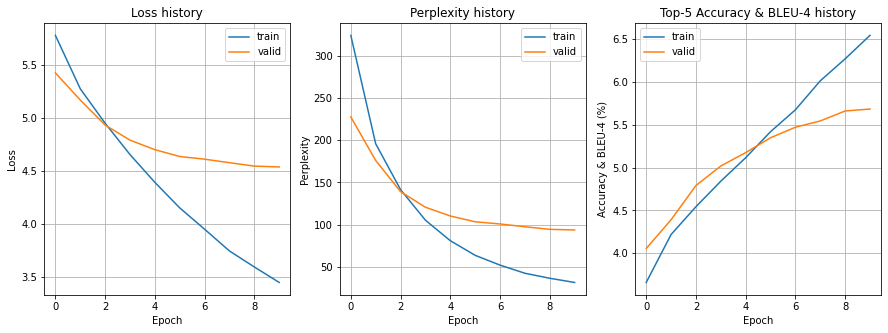

In [18]:
_, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(history['loss'], label='train')
axes[0].plot(history['val_loss'], label='valid')
axes[0].set_title('Loss history')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)
axes[0].legend()

axes[1].plot(history['ppl'], label='train')
axes[1].plot(history['val_ppl'], label='valid')
axes[1].set_title('Perplexity history')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Perplexity')
axes[1].grid(True)
axes[1].legend()

axes[2].plot(history['acc'], label='train')
axes[2].plot(history['val_acc'], label='valid')
axes[2].set_title('Top-5 Accuracy & BLEU-4 history')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy & BLEU-4 (%)')
axes[2].grid(True)
axes[2].legend()

plt.show()

# Evaluation 

## Beam search & BLEU score

In [19]:
#find the best path + defining Node
def find_path(tree):
    path = []
    for nodes in reversed(tree):
        if len(path) == 0:
            path.append(nodes[0])
        else:
            parent_id = path[-1].parent_id
            for node in nodes:
                if node.id == parent_id:
                    path.append(node)
    return path

def find_best_path(tree):
    best = []
    for nodes in reversed(tree):
        if len(best) == 0:
            best.append(nodes[0])
        else:
            nodes_eos = []
            parent_id = best[-1].parent_id
            for node in nodes:
                if node.eos:
                    nodes_eos.append(node)
                if node.id == parent_id:
                    best.append(node)
            if len(nodes_eos) > 0:
                candidates = sorted([best[-1], *nodes_eos],
                                    key=lambda node: node.logps,
                                    reverse=True)
                candidate = candidates[0]
                if candidate.eos:
                    best = [candidate]
    return best

class Node:
    id_ = 0
    
    def __init__(self, token, states, logp=0., parent=None, eos=False):
        self.__id = self.__class__.id_
        self.__token = token
        self.__states = states
        self.__logp = logp
        self.__parent_id = None if parent is None else parent.id
        self.__eos = eos
        self.__level = 0 if parent is None else parent.level + 1
        self.__logps = logp if parent is None else parent.logps + logp
        self.__class__.id_ += 1
        
    def __str__(self):
        return f'Node[id={self.__id}, ' + \
                    f'index={EN.vocab.itos[self.__token.cpu().item()]}, ' + \
                    f'logp={self.__logp}, ' + \
                    f'logps={self.__logps}, ' + \
                    f'parent_id={self.__parent_id}, ' + \
                    f'level={self.__level}]'
    
    @property
    def token(self):
        return self.__token
    
    @token.setter
    def token(self, token):
        self.__token = token
    
    @property
    def parent_id(self):
        return self.__parent_id
    
    @parent_id.setter
    def parent_id(self, parent_id):
        self.__parent_id = parent_id
        
    @property
    def id(self):
        return self.__id
    
    @id.setter
    def id(self, id_):
        self.__id = id_
    
    @property
    def token(self):
        return self.__token
    
    @token.setter
    def token(self, token):
        self.__token = token
    
    @property
    def states(self):
        return self.__states
    
    @states.setter
    def states(self, states):
        self.__states = states
      
    @property
    def eos(self):
        return self.__eos
    
    @eos.setter
    def eos(self, eos):
        self.__eos = eos
    
    @property
    def logps(self):
        return self.__logps
    
    @logps.setter
    def logps(self, logps):
        self.__logps = logps
        
    @property
    def level(self):
        return self.__level
    
    @level.setter
    def level(self, level):
        self.__level = level

In [20]:
def evaluate(model, data, beam_size, French_field, dest_field, max_len, device):
    French_sentences = [*map(lambda example: example.French, data.examples)]
    dest_sentences = [*map(lambda example: example.English, data.examples)]
    data = [*zip([*map(lambda word_list: French_field.process([word_list]), French_sentences)],
                 [*map(lambda word_list: dest_field.process([word_list]), dest_sentences)])]
    references, hypotheses, sources = [], [], []
    model.eval()
    with torch.no_grad():
        for i, ((French_sequence, French_length), (dest_sequence, dest_length)) in tqdm.tqdm(enumerate(data), total=len(data)):
            French_sequence, French_length = French_sequence.to(device), French_length.to(device)
            dest_sequence, dest_length = dest_sequence.to(device), dest_length.to(device)
            
            # Encoding
            h_state = model.encoder(input_sequences=French_sequence, sequence_lengths=French_length) # Encode
            h_state = model.init_h0(h_state.permute(1, 2, 0)) # [batch_size, hidden_size, n_layers]
            h_state = h_state.permute(2, 0, 1) # [n_layers, batch_size, hidden_size]

            # Decoding
            tree = [[Node(token=torch.LongTensor([dest_field.vocab.stoi[dest_field.init_token]]).to(device), states=(h_state,))]]
            for _ in range(max_len):
                next_nodes = []
                for node in tree[-1]:
                    if node.eos: # Skip eos token
                        continue
                    logit, h_state = model.decoder(input_word_index=node.token, h_state_prev=node.states[0].contiguous()) # Decode
                    # logit: [1, vocab_size]
                    # h_state: [n_layers, 1, hidden_size]
                    # c_state: [n_layers, 1, hidden_size]

                    logp = F.log_softmax(logit, dim=1).squeeze(dim=0) # [vocab_size] Get scores                    
                    topk_logps, topk_tokens = torch.topk(logp, beam_size) # Get top k tokens & logps
                    for k in range(beam_size):
                        next_nodes.append(Node(token=topk_tokens[k, None], states=(h_state,),
                                               logp=topk_logps[k, None].cpu().item(), parent=node,
                                               eos=topk_tokens[k].cpu().item() == dest_field.vocab[dest_field.eos_token]))
                if len(next_nodes) == 0:
                    break
                next_nodes = sorted(next_nodes, key=lambda node: node.logps, reverse=True) # Sort next_nodes to get the best
                tree.append(next_nodes[:beam_size]) # Update the tree
                
            best_path = find_best_path(tree) # Find the best path of the tree

            # Get the translation
            pred_translated = [*map(lambda node: dest_field.vocab.itos[node.token], best_path)]
            pred_translated = [*filter(lambda word: word not in [dest_field.init_token, dest_field.eos_token], pred_translated[::-1])]

            hypotheses.append(pred_translated) # Update hypotheses

            # Update references
            references.append([[dest_field.vocab.itos[indice] for indice in dest_sequence if indice not in (
                dest_field.vocab.stoi[dest_field.init_token],
                dest_field.vocab.stoi[dest_field.eos_token],
                dest_field.vocab.stoi[dest_field.pad_token]
            )]])

            # Update sources
            sources.append([French_field.vocab.itos[indice]  for indice in French_sequence  if indice not in (
                French_field.vocab.stoi[French_field.init_token],
                French_field.vocab.stoi[French_field.eos_token],
                French_field.vocab.stoi[French_field.pad_token]
            )])
    
        assert len(hypotheses) == len(references) == len(sources)
        bleu4 = bleu_score(hypotheses, references, max_n=4, weights=[0.25, 0.25, 0.25, 0.25]) # Calculate BLEU-4 score
    return hypotheses, references, sources, bleu4

In [21]:
def evaluate(model, data, beam_size, src_field, dest_field, max_len, device):
    src_sentences = [*map(lambda example: example.src, data.examples)]
    dest_sentences = [*map(lambda example: example.trg, data.examples)]
    data = [*zip([*map(lambda word_list: src_field.process([word_list]), src_sentences)],
                 [*map(lambda word_list: dest_field.process([word_list]), dest_sentences)])]
    references, hypotheses, sources = [], [], []
    model.eval()
    with torch.no_grad():
        for i, ((src_sequence, src_length), (dest_sequence, dest_length)) in tqdm.tqdm(enumerate(data), total=len(data)):
            src_sequence, src_length = src_sequence.to(device), src_length.to(device)
            dest_sequence, dest_length = dest_sequence.to(device), dest_length.to(device)
            
            # Encoding
            h_state = model.encoder(input_sequences=src_sequence, sequence_lengths=src_length) # Encode
            h_state = model.init_h0(h_state.permute(1, 2, 0)) # [batch_size, hidden_size, n_layers]
            h_state = h_state.permute(2, 0, 1) # [n_layers, batch_size, hidden_size]

            # Decoding
            tree = [[Node(token=torch.LongTensor([dest_field.vocab.stoi[dest_field.init_token]]).to(device), states=(h_state,))]]
            for _ in range(max_len):
                next_nodes = []
                for node in tree[-1]:
                    if node.eos: # Skip eos token
                        continue
                    logit, h_state = model.decoder(input_word_index=node.token, h_state_prev=node.states[0].contiguous()) # Decode
                    # logit: [1, vocab_size]
                    # h_state: [n_layers, 1, hidden_size]
                    # c_state: [n_layers, 1, hidden_size]

                    logp = F.log_softmax(logit, dim=1).squeeze(dim=0) # [vocab_size] Get scores                    
                    topk_logps, topk_tokens = torch.topk(logp, beam_size) # Get top k tokens & logps
                    for k in range(beam_size):
                        next_nodes.append(Node(token=topk_tokens[k, None], states=(h_state,),
                                               logp=topk_logps[k, None].cpu().item(), parent=node,
                                               eos=topk_tokens[k].cpu().item() == dest_field.vocab[dest_field.eos_token]))
                if len(next_nodes) == 0:
                    break
                next_nodes = sorted(next_nodes, key=lambda node: node.logps, reverse=True) # Sort next_nodes to get the best
                tree.append(next_nodes[:beam_size]) # Update the tree
                
            best_path = find_best_path(tree) # Find the best path of the tree

            # Get the translation
            pred_translated = [*map(lambda node: dest_field.vocab.itos[node.token], best_path)]
            pred_translated = [*filter(lambda word: word not in [dest_field.init_token, dest_field.eos_token], pred_translated[::-1])]

            hypotheses.append(pred_translated) # Update hypotheses

            # Update references
            references.append([[dest_field.vocab.itos[indice] for indice in dest_sequence if indice not in (
                dest_field.vocab.stoi[dest_field.init_token],
                dest_field.vocab.stoi[dest_field.eos_token],
                dest_field.vocab.stoi[dest_field.pad_token]
            )]])

            # Update sources
            sources.append([src_field.vocab.itos[indice]  for indice in src_sequence  if indice not in (
                src_field.vocab.stoi[src_field.init_token],
                src_field.vocab.stoi[src_field.eos_token],
                src_field.vocab.stoi[src_field.pad_token]
            )])
    
        assert len(hypotheses) == len(references) == len(sources)
        bleu4 = bleu_score(hypotheses, references, max_n=4, weights=[0.25, 0.25, 0.25, 0.25]) # Calculate BLEU-4 score
    return hypotheses, references, sources, bleu4

In [22]:
seq2seq.load_state_dict(torch.load('seq2seq.pth'))
seq2seq.to(DEVICE)

SeqToSeqNet(
  (encoder): EncoderLayer(
    (embedding): Embedding(11545, 300)
    (gru): GRU(300, 256, num_layers=2, dropout=0.25, bidirectional=True)
  )
  (decoder): DecoderLayer(
    (embedding): Embedding(8777, 300)
    (gru): GRU(300, 256, num_layers=2, dropout=0.25)
    (fc): Linear(in_features=256, out_features=8777, bias=True)
  )
  (init_h0): Linear(in_features=4, out_features=2, bias=True)
)

In [23]:
bleu_scores = []
for beam_size in [1, 3, 5]:
    for name, data in [('validation', valid), ('test', test)]:
        _, _, _, bleu4 = evaluate(model=seq2seq, data=data, beam_size=beam_size, src_field=FR_TEXT, dest_field=EN_TEXT, max_len=50, device=DEVICE)
        bleu_scores.append((beam_size, name, bleu4))
        
for bleu_score in bleu_scores:
    print(f'BLEU-4: {bleu_score[2]*100:.3f}% with beam_size={bleu_score[0]} on {bleu_score[1]} data')

100%|██████████| 987/987 [02:28<00:00,  6.66it/s]


BLEU-4: 6.395% with beam_size=1 on validation data
BLEU-4: 6.243% with beam_size=1 on test data
BLEU-4: 7.306% with beam_size=3 on validation data
BLEU-4: 6.928% with beam_size=3 on test data
BLEU-4: 7.439% with beam_size=5 on validation data
BLEU-4: 7.045% with beam_size=5 on test data


## Inference

In [24]:
def translate(sentences, model, beam_size, src_field, dest_field, max_len, device):
    if isinstance(sentences, list):
        sentences = [*map(src_field.preprocess, sentences)]
        targets = None
    if isinstance(sentences, Dataset):
        targets = [*map(lambda example: ' '.join(example.trg), sentences.examples)]
        sentences = [*map(lambda example: example.src, sentences.examples)]
    data = [*map(lambda word_list: src_field.process([word_list]), sentences)]
    translated_sentences, pred_logps = [], []
    model.eval()
    with torch.no_grad():
        for i, (src_sequence, src_length) in tqdm.tqdm(enumerate(data), total=len(data)):
            src_sequence, src_length = src_sequence.to(device), src_length.to(device)
            h_state = model.encoder(input_sequences=src_sequence, sequence_lengths=src_length) # Encode
            h_state = model.init_h0(h_state.permute(1, 2, 0)) # [batch_size, hidden_size, n_layers]
            h_state = h_state.permute(2, 0, 1) # [n_layers, batch_size, hidden_size]
            tree = [[Node(token=torch.LongTensor([dest_field.vocab.stoi[dest_field.init_token]]).to(device), states=(h_state,))]]
            for _ in range(max_len):
                next_nodes = []
                for node in tree[-1]:
                    if node.eos: # Skip eos token
                        continue
                    logit, h_state = model.decoder(input_word_index=node.token, h_state_prev=node.states[0].contiguous())
                    logp = F.log_softmax(logit, dim=1).squeeze(dim=0)                   
                    topk_logps, topk_tokens = torch.topk(logp, beam_size)
                    for k in range(beam_size):
                        next_nodes.append(Node(token=topk_tokens[k, None], states=(h_state,),
                                               logp=topk_logps[k, None].cpu().item(), parent=node,
                                               eos=topk_tokens[k].cpu().item() == dest_field.vocab[dest_field.eos_token]))
                if len(next_nodes) == 0:
                    break
                next_nodes = sorted(next_nodes, key=lambda node: node.logps, reverse=True)
                tree.append(next_nodes[:beam_size])
            best_path = find_best_path(tree)
            # Get the translation
            pred_translated = [*map(lambda node: dest_field.vocab.itos[node.token], best_path)]
            pred_translated = [*filter(lambda word: word not in [
                dest_field.init_token, dest_field.eos_token
            ], pred_translated[::-1])]
            translated_sentences.append(' '.join(pred_translated))
            # Get probabilities
            pred_logps.append(sum([*map(lambda node: node.logps, best_path)]))
        sentences = [*map(lambda sentence: ' '.join(sentence), sentences)]
    return sentences, translated_sentences, targets, pred_logps

In [25]:
sentences, translated_sentences, dest_sentences, pred_logps = translate(sentences=test, model=seq2seq, beam_size=5, src_field=FR_TEXT,
                                                                        dest_field=EN_TEXT, max_len=50, device=DEVICE)
indexes = np.random.choice(len(test.examples), size=10, replace=False)
print(indexes)
print()
for i in indexes:
    html = f'<p><span style="color:black"><b>Source:</b> {sentences[i]}</span><br />'
    html += f'<span style="color:black"><b>Ground truth translation:</b> {dest_sentences[i]}</span><br />'
    html += f'<span style="color:pink"><b>Predicted translation:</b> {translated_sentences[i]}</span></p>'
    display(HTML(html))
    print('='*100)

100%|██████████| 987/987 [02:24<00:00,  6.82it/s]

[478  66 370 869 137 323 546 100 969 245]

